# Recovering data from images

First, make sure you have `scipy` and `pillow` available; I recommend installing them with `conda`. 

Then (and these are really optional) you will need to do this in your virtual env:

    pip install colormath
    
    git clone git://github.com/jcrudy/py-earth.git
    cd py-earth
    python setup.py install

In [163]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Make an image

Make some fake data and apply a colourmap.

In [164]:
from scipy import signal

In [165]:
nx, ny = 100, 100
z = np.random.rand(nx, ny)

sizex, sizey = 30, 30
x, y = np.mgrid[-sizex:sizex+1, -sizey:sizey+1]
g = np.exp(-0.333*(x**2/float(sizex)+y**2/float(sizey)))
f = g/g.sum()

z = signal.convolve(z, f, mode='valid')
z = (z - z.min())/(z.max() - z.min())

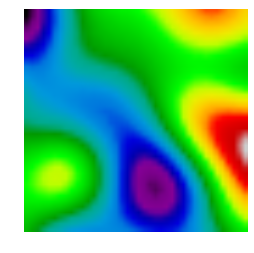

In [166]:
plt.imshow(z, cmap="spectral")
plt.axis('off')
plt.savefig('data/cbar/test.png', bbox_inches='tight')
plt.show()

## Import image with PIL and pre-process

In [188]:
from PIL import Image
im = Image.open('data/cbar/test.png')

In [189]:
im.size

(254, 253)

Instead of taking a random sample, let's take all pixels from a smaller version of the image. **Open question:** is this wise? Resizing can combine pixels and (I think?) make new colours that are not in the original image. 

Also note: we don't need to do this if we're quantizing, because then we're working with a lot less data.

In [190]:
#im = im.resize((100,100))

Cast as an array, and ignore the last channel (alpha), if there is one.

In [191]:
data = np.asarray(im)[:,:,:3]

Now we can plot all the pixels in the image into (R, G, B) space. As an added bonus, we can also colour the points with that (R, G, B) colour. 

In [193]:
# Re-organize the pixels to use rgb triples for colour
h, w, d = data.shape
c = data.reshape((h*w, d)) / 255

**Careful, for large images, this plot will take a long time to render. Less than 256 x 256 is fine.**

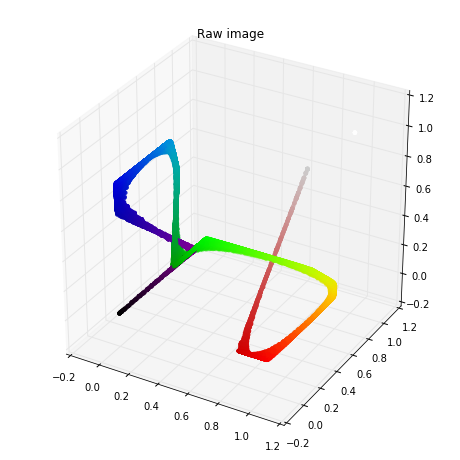

In [195]:
from mpl_toolkits.mplot3d import Axes3D

# Set up the figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the pixels!
ax.scatter(*c.T, c=c, lw=0)
ax.set_title('Raw image')

plt.show()

## Quantize with PIL

Really handy in principle, but PIL quantization is a bit of a black box, and gives unpredictable results. 

In practice, we'll use SciKit quantization.

In [174]:
# QUANTIZED with PIL
q = np.array(im.convert("P", palette=Image.ADAPTIVE).convert('RGB'))
h, w, _ = q.shape
q = q.reshape((h*w, 3)) / 255

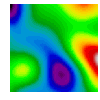

In [175]:
im.convert("P", palette=Image.ADAPTIVE).convert('RGB')

In [187]:
# QUANTIZED IMAGE PALETTE
p = np.array(im.convert("P", palette=Image.ADAPTIVE).getpalette()).reshape((256,3)) / 255

We could plot all the pixels, but there's no point: we can just plot the palette. They look the same, but the whole image obvsly has a lot more points per location in colour space.

Note that there are 256 rows in `p`:

In [177]:
p.shape

(256, 3)

But there are actually much fewer unique points (as we can discover later in this notebook, or you can count the points in this crossplot...

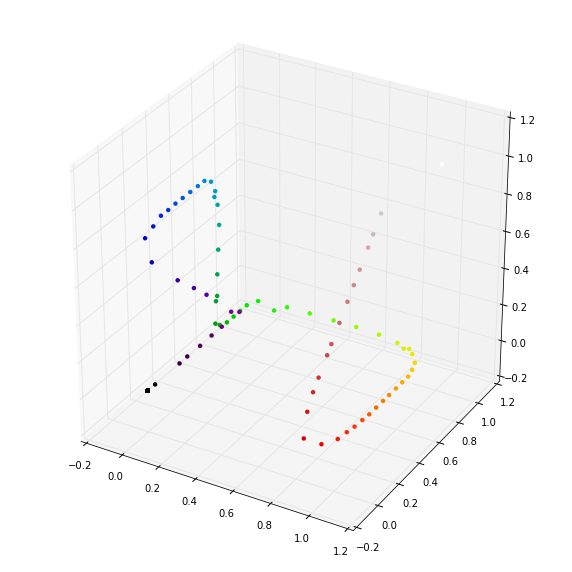

In [178]:
from mpl_toolkits.mplot3d import Axes3D

# Set up the figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the pixels!
ax.scatter(*p.T, c=p, lw=0, alpha=1)
plt.show()

## Quantize with NeuQuant

NeuQuant is a neural net image quantizer. This implementation is adapted [from here](https://github.com/luopio/bag-of-tricks/blob/master/python/images2gif.py). 

Maybe I'm doing something wrong, but it doesn't seem to work very nicely on most images.

In [179]:
from neuquant import NeuQuant
pnq = NeuQuant(im, samplefac=8, colors=128) 

Beginning 1D learning: samplepixels = 8032.75  rad = 16
1.2449036755781022%

2.4898073511562044%

3.734711026734306%

4.979614702312409%

6.224518377890511%

7.469422053468612%

8.714325729046715%

9.959229404624818%

11.204133080202919%

12.449036755781021%

13.693940431359124%

14.938844106937225%

16.18374778251533%

17.42865145809343%

18.67355513367153%

19.918458809249636%

21.163362484827736%

22.408266160405837%

23.65316983598394%

24.898073511562043%

26.142977187140144%

27.387880862718248%

28.63278453829635%

29.87768821387445%



In [180]:
p = pnq.colormap[:,:3]

In [181]:
p.shape

(128, 3)

Distance: 18.79


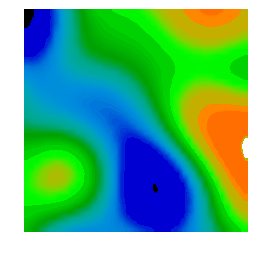

In [182]:
pnq.quantize_with_scipy(im)

Well, that didn't work.

## Quantize with scikit

In [131]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [132]:
im = Image.open('data/cbar/test.png')

In [133]:
im = np.array(im) / 255
h, w, d = im.shape
image_array = im.reshape((w * h, d))
sample = shuffle(image_array, random_state=0)[:1000]

In [134]:
im.dtype

dtype('float64')

In [135]:
kmeans = KMeans(n_clusters=256, random_state=0).fit(sample)

Now I can make and regularize an RGB palette `p`:

In [136]:
p = kmeans.cluster_centers_[:, :3]

# Make certain we're in [0, 1]
p[p<1e-9] = 0
p[p>1] = 1

In [137]:
labels = kmeans.predict(image_array)

In [138]:
def recreate_image(palette, labels, h, w):
    image = np.zeros((h, w, palette.shape[1]))
    label_idx = 0
    for i in range(h):
        for j in range(w):
            image[i][j] = palette[labels[label_idx]]
            label_idx += 1
    return image

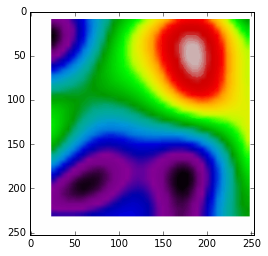

In [139]:
plt.imshow(recreate_image(p, labels, h, w))

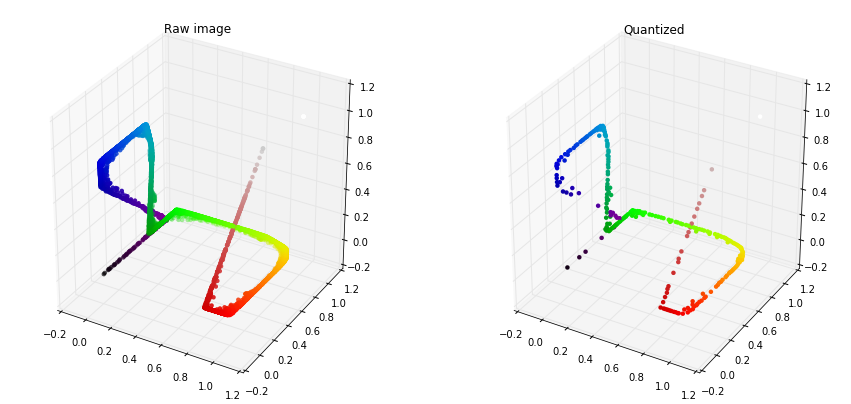

In [84]:
from mpl_toolkits.mplot3d import Axes3D

# Set up the figure
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(121, projection='3d')

# Plot the pixels!
ax.scatter(*c.T, c=c, lw=0)
ax.set_title('Raw image')

# Plot more pixels!
ax1 = fig.add_subplot(122, projection='3d')
ax1.scatter(*p.T, c=p, lw=0, alpha=1)
ax1.set_title('Quantized')

plt.show()

## Convert to CIELab

This is not necessary.

In [85]:
from colormath.color_objects import XYZColor, sRGBColor, LabColor
from colormath.color_conversions import convert_color

out = []
for pixel in p:
    rgb = sRGBColor(*pixel)
    xyz = convert_color(rgb, XYZColor, target_illuminant='d65')
    out.append(convert_color(xyz, LabColor))

In [86]:
o = np.array([(l.lab_l, l.lab_a, l.lab_b) for l in out])

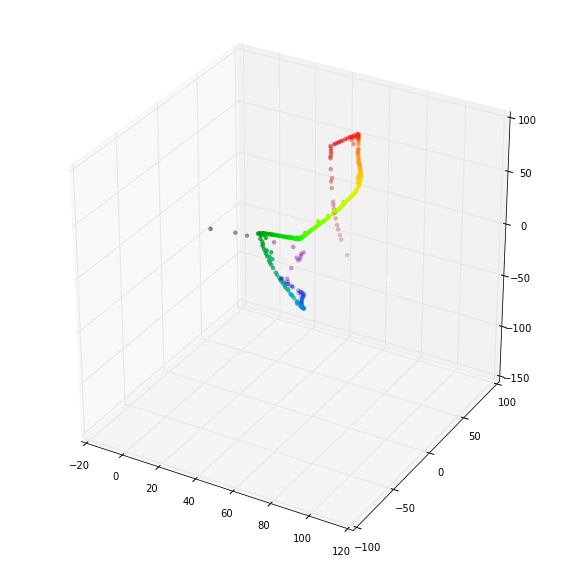

In [87]:
# Set up the figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the pixels!
ax.scatter(*o.T, c=p, lw=0)
plt.show()

## Reconstructing the colourmap locus

Remember that these points are essentially in random order, and that there are many, many duplicates. Most of those dots are actually hundreds of dots.

We would like to measure ditances between dots. This is just a norm, but there's a convenient function in `scipy.spatial` for finding distances in *n*-space.

In [88]:
from scipy.spatial.distance import pdist, squareform, cdist
distances = squareform(pdist(p))

In [89]:
distances.shape, distances.size

((256, 256), 65536)

Each row is the set of distances for a point. Below is an excerpt of only the first 100 points.

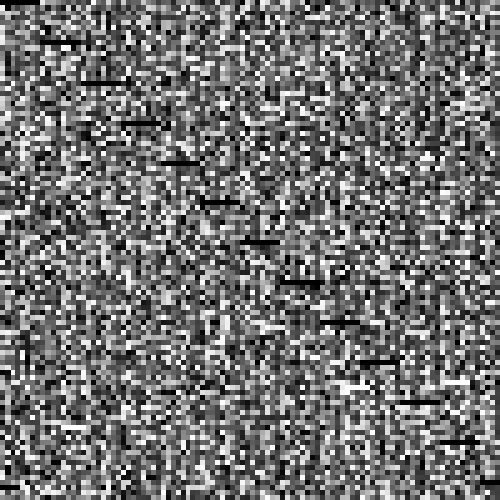

In [90]:
# The image is 10k x 10k pixels, so let's just look at a bit of it...
dist_img = Image.fromarray(distances[:100, :100]*255, 'P').resize((500, 500))
dist_img

I need an algorithm. I think this might work:

#### Preprocessing

* Find the median minimum non-zero distance between points, _m_ (nonzero because many points are exactly the same — colourbars are often only 6 or 8 bit).
* We are interested in points that are close to each other, but outside some minimum distance. Below the minimum distance, it's basically the same point. So ignore everything closer than some small distance _n_. Let's set _n_ to 0.2 &times; _m_ (we may need to change this).
* We want to eliminate points that are further than some maximum separation distance from the other points. Let's set _x_ to 5 &times; _m_.

#### Main loop

* Find the point nearest the origin. I think the blackest point is generally going to be the closest to 'zero' on the colorbar.
* Find the nearest point that is at least _n_ away.
* If the point is more than _x_ away, eliminate everything done so far and continue.
* If the point is less than _x_ away, keep the current points and continue.

After this, we'll have a minimal set of points, in order from blackest to the other end of the locus, wherever that is (not necessarily far from where we started.

In [91]:
# Start by eliminating duplicate rows — only needed for PIL quantization
def unique_rows(a):
    a = np.ascontiguousarray(a)
    unique_a = np.unique(a.view([('', a.dtype)]*a.shape[1]))
    return unique_a.view(a.dtype).reshape((unique_a.shape[0], a.shape[1]))

u = unique_rows(p)

In [92]:
len(u)

256

But we can't use this right now because we need to be able to look up the (r, g, b) triples for the pixels we identify. So we need their original coordinates.

Compute the median non-zero distance... 

In [93]:
dists = squareform(pdist(p))

# This is the only way I could think of to eliminate the zeros and keep the shape.
dists[dists==0] = np.nan
mins = np.nanmin(dists, axis=0)

# Now get the median of these minimum nonzero distances.
m = np.median(mins)

# Now compute those numbers I was talking about.
n = m / 2
x = m * 5

In [94]:
m, n, x

(0.019192694810610093, 0.0095963474053050463, 0.09596347405305046)

Let's compute the distance of every point from the black point, `[0, 0, 0]`.

In [95]:
target = cdist([[0,0,0]], u)
dists = squareform(pdist(u))

In [96]:
hits = [np.argmin(target)]  # Start with the first point.
i = 0

# Discretionary multipler. Higher numbers results in fewer points.
# Essentially, this is like selecting fewer colours to start with.
# 
z = 3

while i < len(u):
    i += 1
    
    # Eliminate everything close to target.
    dists[:, np.squeeze(np.where(target < z*n))] = 10
    target[target < z*n] = 10  # Eliminate everything close to target.

    # Get the next point in the locus.
    nearest = np.argmin(target)
    if nearest not in hits: hits.append(nearest)

    target = dists[nearest, :]

In [97]:
len(hits)

145

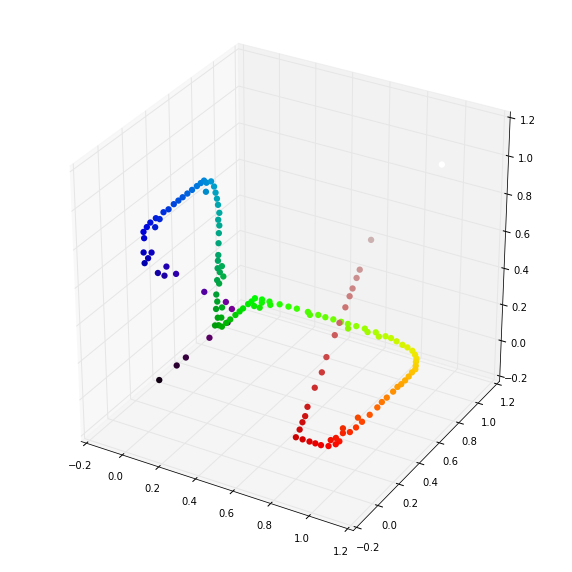

In [98]:
# Set up the figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the pixels!
ax.scatter(*u[hits].T, c=u[hits], lw=0, s=40, alpha=1)
plt.show()

Awesome!

<hr />

## Casting colours to data

Now we have two choices:

1. Treat the points literally, so there are bigger data gaps between some pairs than others, or
1. Assume that these nonlinearities were defects in the original colourbar, and the data is a linspace

To treat as (1) distances along this line:

It would also probably be easiest to eliminate gaps here, so let's do that.

In [99]:
cmap = u[hits]
cmap[:5]

array([[ 0.06666667,  0.        ,  0.07843137],
       [ 0.16470588,  0.        ,  0.18823529],
       [ 0.21568627,  0.        ,  0.24705882],
       [ 0.34509804,  0.        ,  0.39215686],
       [ 0.44313725,  0.        ,  0.50196078]])

In [100]:
cutoff = 2  # There are some big gaps in this colourbar, so this has to be a big number.

In [101]:
import numpy.linalg as la
colours = [cmap[0]]
cumdist = [0]
for pair in zip(cmap[:-1], cmap[1:]):
    thisdist = la.norm(pair[1] - pair[0])
    if thisdist < cutoff:
        cumdist.append(cumdist[-1] + thisdist)
        colours.append(pair[1])
    else:
        cumdist = [0]  # Start again
        colours = [pair[1]]

cumdist = np.array(cumdist) / np.amax(cumdist)

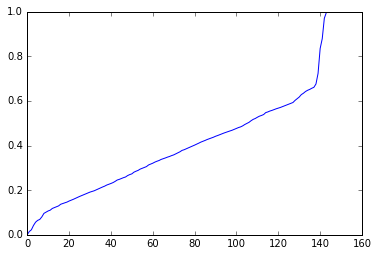

In [102]:
plt.plot(cumdist)
plt.show()

Now, to treat as (2) is easy:

In [103]:
cumdist = np.linspace(0, cumdist[-1], len(cumdist))
cumdist = np.array(cumdist) / np.amax(cumdist)  # Normalize to 1

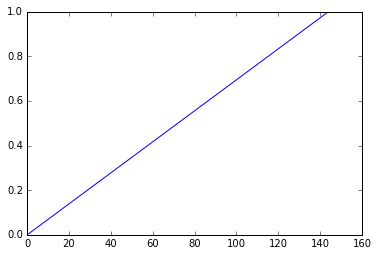

In [104]:
plt.plot(cumdist)

## Get all pixels using nearest neighbour

`cKDTree`, hopefully fast...

In [105]:
from scipy.spatial import cKDTree

In [106]:
kdtree = cKDTree(cmap)

We get distances and indices simultaneously:

In [107]:
dx, ix = kdtree.query(q)

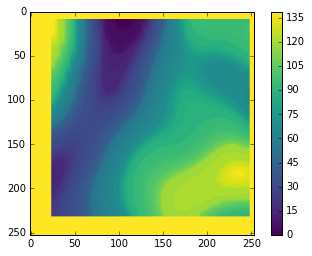

In [108]:
plt.imshow(ix.reshape((h, w)), cmap='viridis')
plt.colorbar()
plt.show()

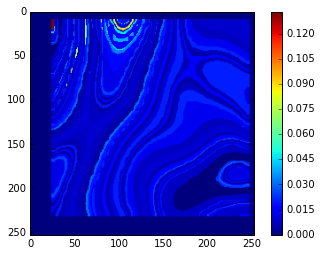

In [109]:
plt.imshow(dx.reshape((h, w)))
plt.colorbar()
plt.show()

We can apply a cutoff where the distance was unacceptably far.

In [114]:
ix = ix.astype(float)
ix[np.where(dx>0.1)] = np.nan

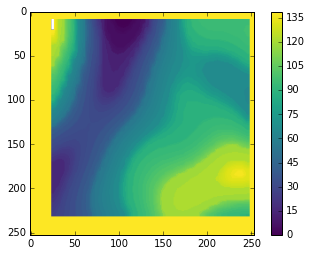

In [115]:
plt.imshow(ix.reshape((h, w)), cmap='viridis')
plt.colorbar()
plt.show()

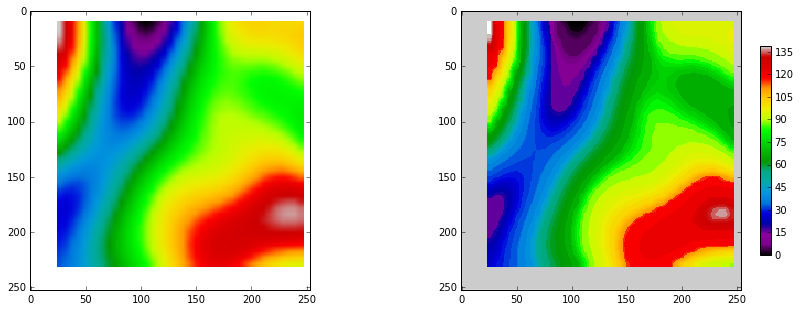

In [116]:
fig = plt.figure(figsize=(15, 5))

ax0 = fig.add_subplot(121)
plt.imshow(im, interpolation='none')

ax1 = fig.add_subplot(122)
plt.imshow(ix.reshape((h, w)), cmap="spectral", interpolation='none')
plt.colorbar(shrink=0.75)

plt.show()

<hr /> 

## Careful...

**Things below here are probably broken.**

In [162]:
all_data = np.asarray(im)[:,:,:3]
all_c = all_data.reshape((np.product(im.size), 3)) / 255

In [469]:
def recover_data(pixels, colours, cumdist):
    all_result = []
    for p in all_c:
        d = cdist(np.expand_dims(p, 0), colours)
        all_result.append(cumdist[np.argmin(d)])
    all_result = np.array(all_result).reshape((im.size[1], im.size[0]))
    return all_result

In [470]:
all_result = recover_data(all_c, colours, cumdist)

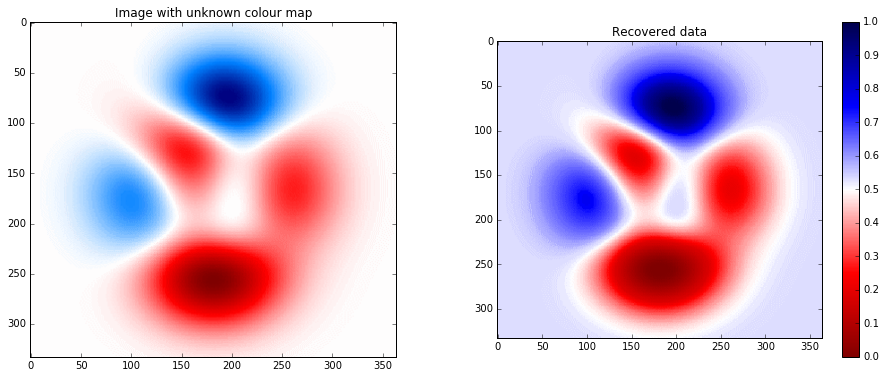

In [471]:
fig = plt.figure(figsize=(16, 6))
ax0 = fig.add_subplot(121)
plt.imshow(im)
ax0.set_title("Image with unknown colour map")
ax1 = fig.add_subplot(122)
plt.imshow(all_result, cmap="seismic_r")
plt.colorbar()
ax1.set_title("Recovered data")
plt.show()

## Let's try MARS

If you want to try using the MARS alogithm, via [py-earth](https://github.com/jcrudy/py-earth), you will need to do this in your virtual env:

    git clone git://github.com/jcrudy/py-earth.git
    cd py-earth
    python setup.py install

In [472]:
from pyearth import Earth

In [473]:
X = u[hits]                                     # Defines locus - points in order.
y = np.arange(0, X.shape[0], 1)/(X.shape[0]-1)  # Normalized distances along locus.

In [547]:
model = Earth(max_degree=3)
model.fit(X,y)

Earth(allow_linear=None, allow_missing=False, check_every=None,
   enable_pruning=True, endspan=None, endspan_alpha=None, fast_K=None,
   fast_h=None, max_degree=3, max_terms=None, min_search_points=None,
   minspan=None, minspan_alpha=None, penalty=None, smooth=None,
   thresh=None, use_fast=None, zero_tol=None)

In [548]:
# print(model.trace())
# print(model.summary())

In [549]:
y_hat = model.predict(X)

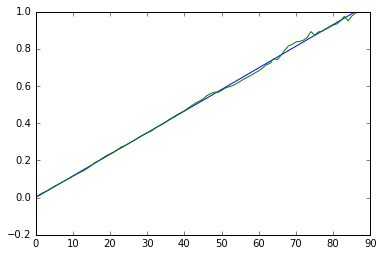

In [550]:
plt.plot(y)
plt.plot(y_hat)
plt.show()

In [551]:
h, w, d = im.shape
image_array = im.reshape((w * h, d)) * 255
c_hat = model.predict(image_array)

In [552]:
result = c_hat.reshape((w, h))

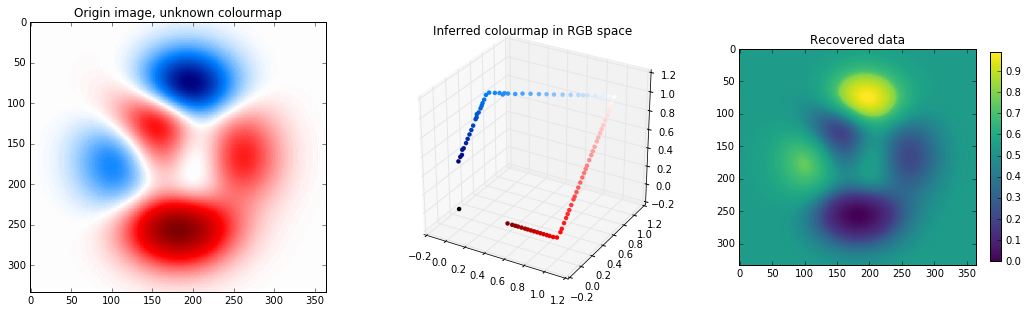

In [579]:
fig = plt.figure(figsize=(18, 5))

ax0 = fig.add_subplot(131)
plt.imshow(im*255)
ax0.set_title("Origin image, unknown colourmap")

ax = fig.add_subplot(132, projection='3d')
ax.scatter(*u[hits].T, c=u[hits], lw=0, alpha=1, s=20)
ax.set_title("Inferred colourmap in RGB space")

ax1 = fig.add_subplot(133)
plt.imshow(result, cmap="viridis")
plt.colorbar(shrink=0.75)
ax1.set_title("Recovered data")

plt.show()

In [562]:
im.size

(364, 333)

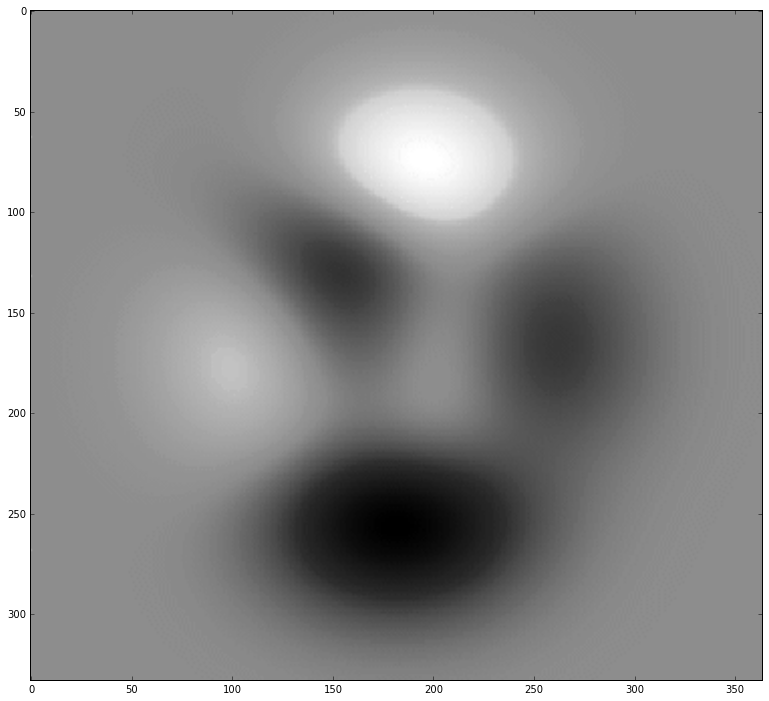

In [563]:
fig = plt.figure(figsize=(16, 12))
plt.imshow(result, cmap="gray")
plt.show()

## Make an MPL colourbar from the 'discovered' colourbar

In [564]:
colours = u[hits]

[array([ 0.49803922,  0.        ,  0.        ]),
 array([ 0.54509804,  0.        ,  0.        ]),
 array([ 0.57647059,  0.        ,  0.        ]),
 array([ 0.60392157,  0.        ,  0.        ]),
 array([ 0.63921569,  0.        ,  0.        ]),
 array([ 0.6745098,  0.       ,  0.       ]),
 array([ 0.70196078,  0.        ,  0.        ]),
 array([ 0.73333333,  0.        ,  0.        ]),
 array([ 0.76470588,  0.        ,  0.        ]),
 array([ 0.79607843,  0.        ,  0.        ]),
 array([ 0.82745098,  0.        ,  0.        ]),
 array([ 0.85882353,  0.        ,  0.        ]),
 array([ 0.89019608,  0.        ,  0.        ]),
 array([ 0.91764706,  0.        ,  0.        ]),
 array([ 0.95294118,  0.        ,  0.        ]),
 array([ 0.98823529,  0.00392157,  0.00392157]),
 array([ 1.        ,  0.04313725,  0.04313725]),
 array([ 1.        ,  0.06666667,  0.06666667]),
 array([ 1.        ,  0.10588235,  0.10588235]),
 array([ 1.        ,  0.14117647,  0.14117647]),
 array([ 1.        ,  0

In [565]:
# setting up color arrays
r1 = np.array(colours)[:, 0] # value of Red for the nth sample
g1 = np.array(colours)[:, 1] # value of Green for the nth sample
b1 = np.array(colours)[:, 2] # value of Blue for the nth sample

r2 = r1 # value of Red at the nth sample
r0 = np.linspace(0, 1, len(r1)) # position of the nth Red sample within the range 0 to 1

g2 = g1 # value of Green at the nth sample
g0 = np.linspace(0, 1, len(g1)) # position of the nth Green sample within the range 0 to 1

b2 = b1 # value of Blue at the nth sample
b0 = np.linspace(0, 1, len(b1)) # position of the nth Blue sample within the range 0 to 1

# creating lists
R = zip(r0, r1, r2)
G = zip(g0, g1, g2)
B = zip(b0, b1, b2)

# creating list of above lists and transposing
RGB = zip(R, G, B)
rgb = zip(*RGB)
#print rgb

# creating dictionary
k = ['red', 'green', 'blue'] # makes list of keys
data_dict = dict(zip(k,rgb)) # makes a dictionary from list of keys and list of values

# Make a colourbar
import matplotlib.colors as clr

found_cbar = clr.LinearSegmentedColormap('my_colormap', data_dict)


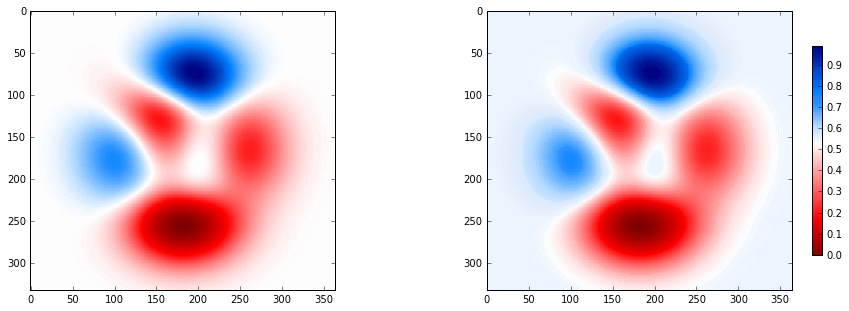

In [567]:
fig = plt.figure(figsize=(16, 5))

ax0 = fig.add_subplot(121)
plt.imshow(im*255)

ax1 = fig.add_subplot(122)
plt.imshow(result, cmap=found_cbar)
plt.colorbar(shrink=0.75)

plt.show()

## All the images

In [28]:
import os
def plot_cbars(dirname):
    flist = os.listdir(dirname)
    for f in flist:
        try:
            im = Image.open(os.path.join(dirname, f))
        except:
            continue
        sm = im.resize((100,100))
        data = np.asarray(sm)[:,:,:3]  # Ignore opacity
        
        # Set up the figure
        fig = plt.figure(figsize=(12, 4))
        ax = fig.add_subplot(121, projection='3d')

        # Resort the pixels to use rgb triples for colour
        d = np.swapaxes(data, 0, 1)
        c = d.reshape((10000, 3)) / 255

        # Plot
        ax.scatter(*data.T/255, c=c, lw=0)
        
        ax1 = fig.add_subplot(122)
        ax1.imshow(data, interpolation='none')
        
        plt.title(f)

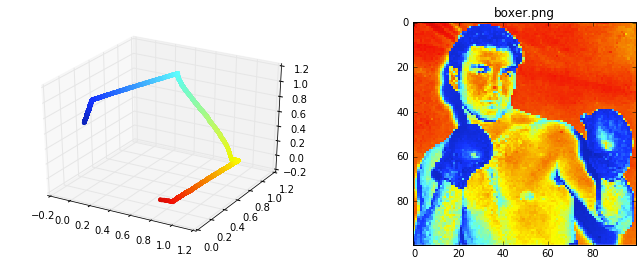

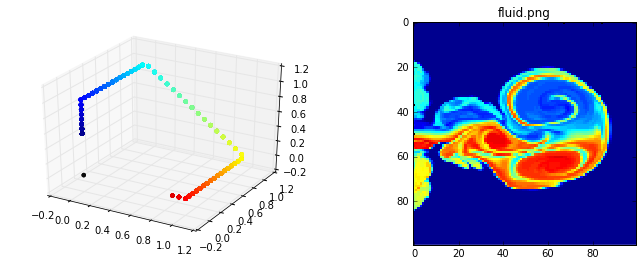

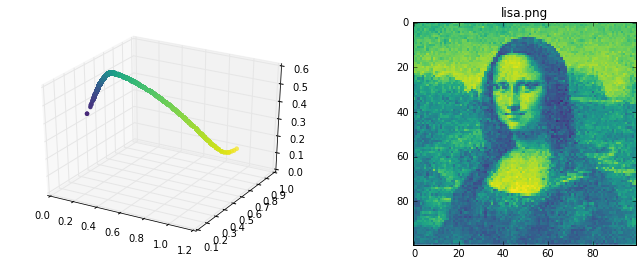

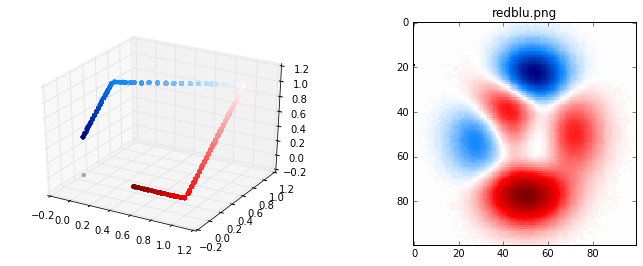

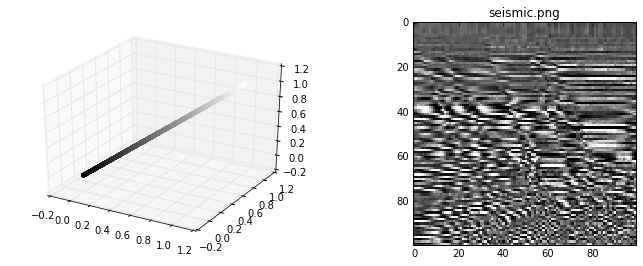

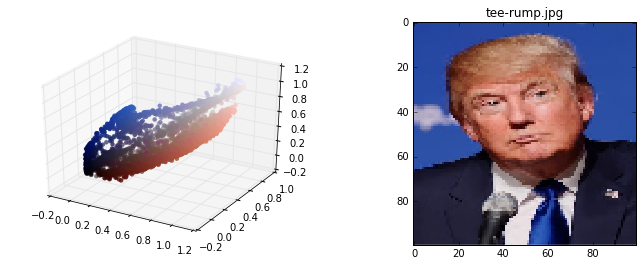

In [29]:
plot_cbars('data/cbar')

In [60]:
d = np.swapaxes(data, 0, 1)
c = d.reshape((10000, 3)) / 255